# Spaceship Titanic Survival Prediction

Dataset: https://www.kaggle.com/competitions/spaceship-titanic/overview

For this project I will use the steps in CRISP-DM, or Cross-Industry Standard Process for Data Mining. It is a widely-used framework for guiding data mining projects from start to finish.

## Step 1: Business Understanding

Let"s predict what sorts of people on the Spaceship Titanic were more likely to survive.

## Step 2: Data Understanding

### Import Packages

In [528]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from itertools import cycle

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score, roc_curve

### Load the data

In [529]:
train_df = pd.read_csv("spaceship-titanic/train.csv")
test_df = pd.read_csv("spaceship-titanic/test.csv")

### View the data

In [530]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [531]:
train_df.shape

(8693, 14)

In [532]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


These are what the columns mean according to the dataset page:

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

We will need the PassengerId column from test_df when we make our submission, so let's save them.

In [533]:
ids = test_df["PassengerId"]

### View Distributions

Let's view some of the columns for the train dataset using histograms. We won't be viewing PassengerId or Name since those are unique.

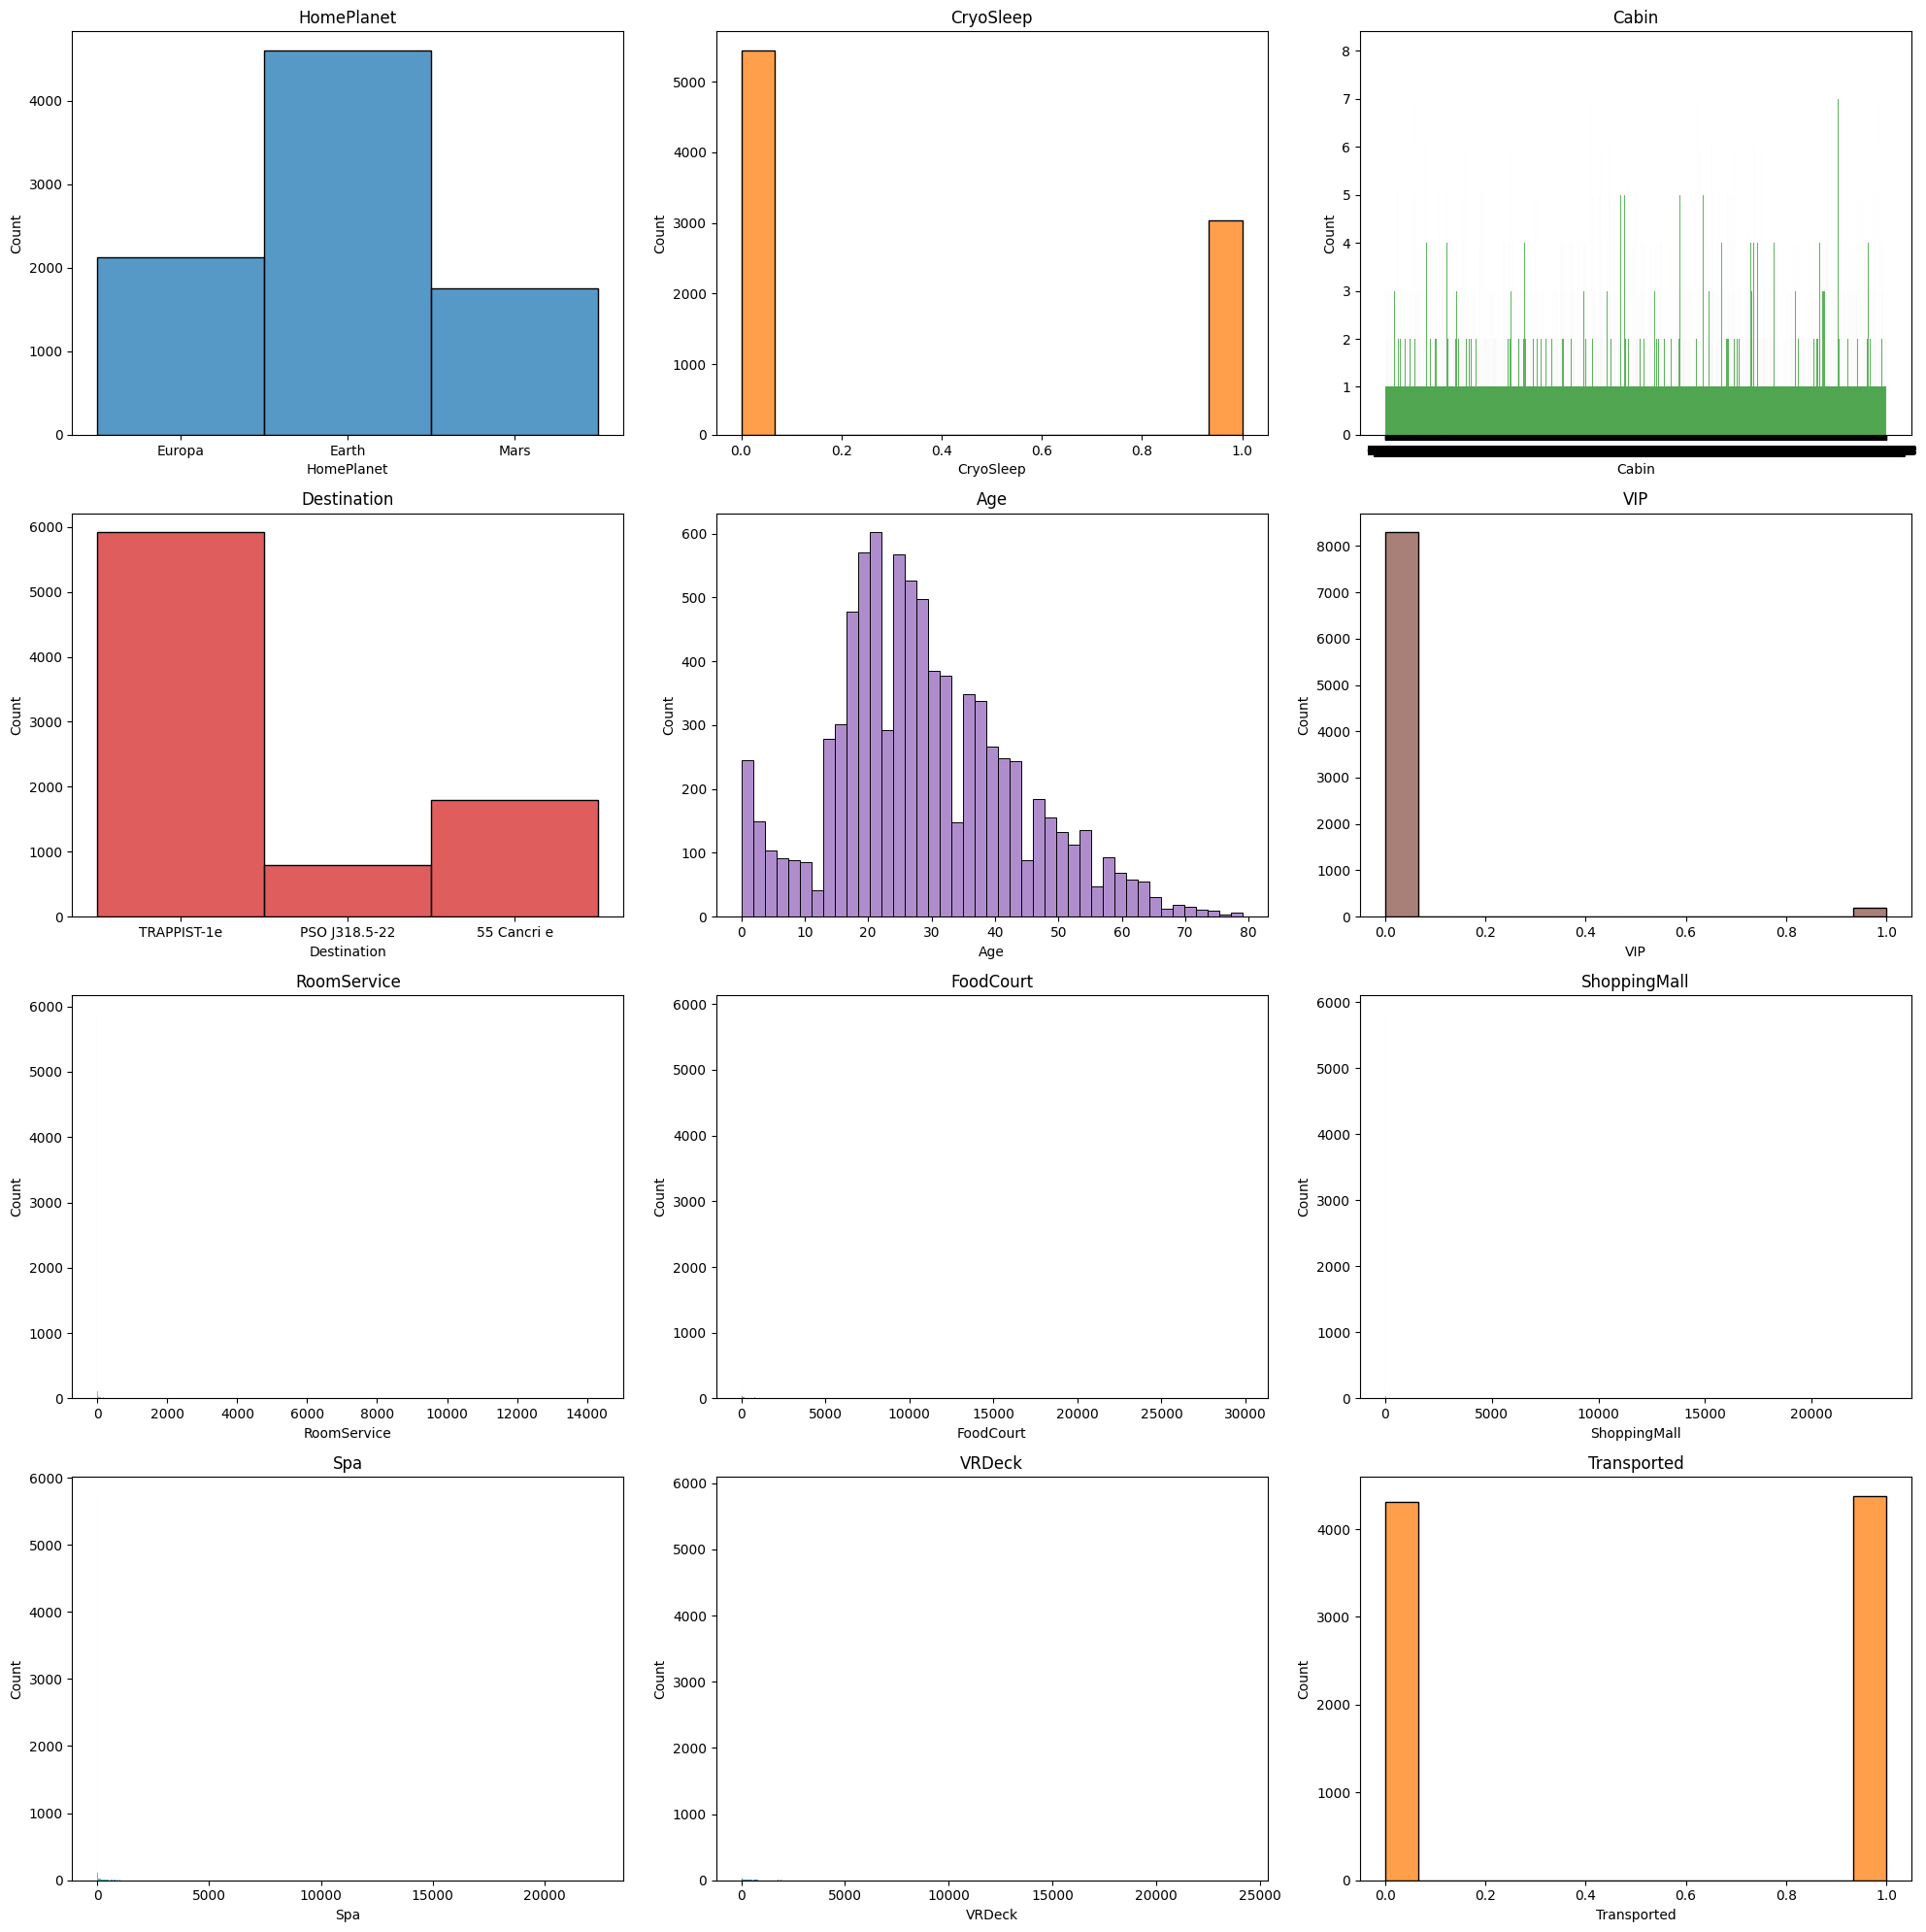

In [534]:
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

subplot_column_names = train_df.columns.drop(["PassengerId", "Name"])

columns_n = len(subplot_column_names)
subplot_rows = 4
subplot_columns = columns_n // subplot_rows

fig, axs = plt.subplots(subplot_rows, subplot_columns, figsize=(20, 20), sharex=False, sharey=False)
axs = axs.flatten()

for i, column in enumerate(subplot_column_names):
    sns.histplot(train_df[column], ax=axs[i], color=next(colors))  # use the next color in the cycle
    axs[i].set_title(column)

# this is so we can hide the unused histograms, there are 0 in this case, but keep for other models
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

A few of the histograms appear to be blank, but they're just mainly unique values or values with low counts.

### Identify Patterns

Some initial assumptions:

- Cabin seems almost unique for all the passengers, but we can break this column into CabinDeck, CabinNum, and CabinSide.
- Age seems to be in groups based on the histogram, let's use another histogram later to verify.
- VIP is heavily skewed towards people that didn't get VIP services.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck are primarily 0, but have some large values that could help our model.
- Transported seems faily balanced, this is very helpful because it ensures that the model is not biased towards a particular outcome.

For the Age histogram, we will make the number of bins the range of the value counts to check if the column is actually in groups.

<Axes: xlabel='Age', ylabel='Count'>

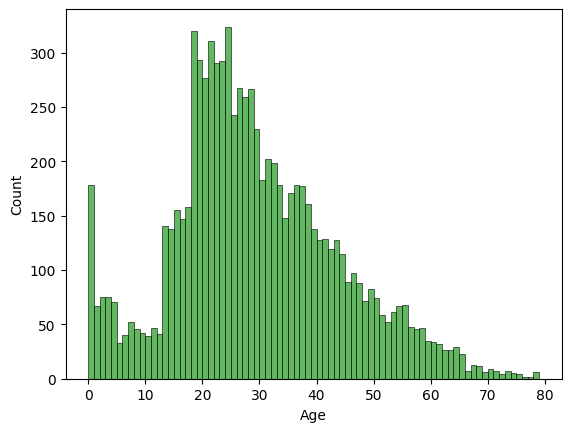

In [535]:
sns.histplot(train_df["Age"], bins=int(max(train_df["Age"]) - min(train_df["Age"])), color=next(colors))

The data here looks normal, so we don't have to do anything.

### Check for Missing Values and Outliers

Now, let's check for missing values or outliers in the data.

In [536]:
train_df.isnull().sum(), test_df.isnull().sum()

(PassengerId       0
 HomePlanet      201
 CryoSleep       217
 Cabin           199
 Destination     182
 Age             179
 VIP             203
 RoomService     181
 FoodCourt       183
 ShoppingMall    208
 Spa             183
 VRDeck          188
 Name            200
 Transported       0
 dtype: int64,
 PassengerId       0
 HomePlanet       87
 CryoSleep        93
 Cabin           100
 Destination      92
 Age              91
 VIP              93
 RoomService      82
 FoodCourt       106
 ShoppingMall     98
 Spa             101
 VRDeck           80
 Name             94
 dtype: int64)

What to do for missing values:

- HomePlanet = make null values Other.
- CryoSleep = make null values True if the passenger has not spent money on amenities, otherwise False.
    - I use this reasoning because if a passenger was in CryoSleep, it means that they were confined to their cabins the entire trip.
- Cabin = this will be broken up into 3 different columns.
    - CabinDeck = set null values to Other.
    - CabinNum = set null values to the median num.
    - CabinSide = set null values to the mode side.
- Destination = make null values Other.
- Age = make null values as the median age since the age histogram is skewed.
- VIP = make null values True if they spent above average on amenities, False otherwise.
- RoomService = make null values 0.
- FoodCourt = make null values 0.
- ShoppingMall = make null values 0.
- Spa = make null values 0.
- VRDeck = make null values 0.
- Name = break up name into first and last names and make null into Other.

There doesn't seem to be any outliers based on the histograms, so we can move on.

## Step 3: Data Preparation

Now we can start cleaning up and preparing the dataframes so they're easier to work with, and give us more accurate results.

In [537]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Clean Up the Feature and Value Names

From an initial look at the dataframe, the feature (column) names are already without spaces and look good in PascalCase so we can keep them as is. The values also look good and don't have any weird strings.

### Feature Engineering

Let's create some new features that'll make filling in the null values easier for us.

Some things we can do to the data:

- PassengerId can be used to make a PassengerGroup feature using the first 4 digits, and a PassengerNum using the last 2 digits.
- Break up Cabin into 3 different columns.
- Name can be broken up into FirstName and LastName.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck can have their values summed up into a Amenities columns.

In [538]:
def data_preparation_0(df):
    df[["PassengerGroup", "PassengerNum"]] = df["PassengerId"].str.split("_", expand=True)

    df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", expand=True)
    df["CabinDeck"] = df["CabinDeck"].fillna("Other")
    df["CabinNum"] = df["CabinNum"].astype(float)
    df["CabinNum"] = df["CabinNum"].fillna(df["CabinNum"].median())
    df["CabinSide"] = df["CabinSide"].fillna(df["CabinSide"].mode()[0])
    df.drop(columns=["Cabin"], inplace=True)

    df[["FirstName", "LastName"]] = df["Name"].str.split(" ", expand=True)
    df["FirstName"] = df["FirstName"].fillna("Other")
    df["LastName"] = df["LastName"].fillna("Other")
    df.drop(columns=["Name"], inplace=True)

    amenities_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    df[amenities_columns] = df[amenities_columns].fillna(0)
    df["Amenities"] = df[amenities_columns].sum(axis=1)
    
data_preparation_0(train_df)
data_preparation_0(test_df)

### Handle Missing Values

We have some more columns, so let's handle the rest of the missing values.

In [539]:
def data_preparation_1(df):
    df["HomePlanet"] = df["HomePlanet"].fillna("Other")
    df["CryoSleep"] = df["CryoSleep"].astype("boolean")
    df["CryoSleep"] = df["CryoSleep"].fillna(df["Amenities"] == 0).astype(int)
    df["Destination"] = df["Destination"].fillna("Other")
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["VIP"] = df["VIP"].astype("boolean")
    df["VIP"] = df["VIP"].fillna(df["Amenities"] >= df["Amenities"].median()).astype(int)

data_preparation_1(train_df)
data_preparation_1(test_df)

In [540]:
train_df.isnull().sum(), test_df.isnull().sum()

(PassengerId       0
 HomePlanet        0
 CryoSleep         0
 Destination       0
 Age               0
 VIP               0
 RoomService       0
 FoodCourt         0
 ShoppingMall      0
 Spa               0
 VRDeck            0
 Transported       0
 PassengerGroup    0
 PassengerNum      0
 CabinDeck         0
 CabinNum          0
 CabinSide         0
 FirstName         0
 LastName          0
 Amenities         0
 dtype: int64,
 PassengerId       0
 HomePlanet        0
 CryoSleep         0
 Destination       0
 Age               0
 VIP               0
 RoomService       0
 FoodCourt         0
 ShoppingMall      0
 Spa               0
 VRDeck            0
 PassengerGroup    0
 PassengerNum      0
 CabinDeck         0
 CabinNum          0
 CabinSide         0
 FirstName         0
 LastName          0
 Amenities         0
 dtype: int64)

Now that we have no null values, we can do some more feature engineering.

Let's look at the value counts of each of the features and see if we can come with any more relationships.

In [541]:
def display_column_value_counts(df):
    for column in df.columns:
        display(df[column].value_counts().sort_index())
        print("\n")

In [542]:
display_column_value_counts(train_df)

PassengerId
0001_01    1
0002_01    1
0003_01    1
0003_02    1
0004_01    1
          ..
9276_01    1
9278_01    1
9279_01    1
9280_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Other      201
Name: count, dtype: int64

CryoSleep
0    5558
1    3135
Name: count, dtype: int64

Destination
55 Cancri e      1800
Other             182
PSO J318.5-22     796
TRAPPIST-1e      5915
Name: count, dtype: int64

Age
0.0     178
1.0      67
2.0      75
3.0      75
4.0      71
       ... 
75.0      4
76.0      2
77.0      2
78.0      3
79.0      3
Name: count, Length: 80, dtype: int64

VIP
0    8395
1     298
Name: count, dtype: int64

RoomService
0.0        5758
1.0         117
2.0          79
3.0          61
4.0          47
           ... 
8209.0        1
8243.0        1
8586.0        1
9920.0        1
14327.0       1
Name: count, Length: 1273, dtype: int64

FoodCourt
0.0        5639
1.0         116
2.0          75
3.0          53
4.0          53
           ... 
21066.0       1
26830.0       1
27071.0       1
27723.0       1
29813.0       1
Name: count, Length: 1507, dtype: int64

ShoppingMall
0.0        5795
1.0         153
2.0          80
3.0          59
4.0          45
           ... 
9058.0        1
10424.0       1
10705.0       1
12253.0       1
23492.0       1
Name: count, Length: 1115, dtype: int64

Spa
0.0        5507
1.0         146
2.0         105
3.0          53
4.0          46
           ... 
15586.0       1
16139.0       1
16594.0       1
18572.0       1
22408.0       1
Name: count, Length: 1327, dtype: int64

VRDeck
0.0        5683
1.0         139
2.0          70
3.0          56
4.0          47
           ... 
16337.0       1
17074.0       1
17306.0       1
20336.0       1
24133.0       1
Name: count, Length: 1306, dtype: int64

Transported
False    4315
True     4378
Name: count, dtype: int64

PassengerGroup
0001    1
0002    1
0003    2
0004    1
0005    1
       ..
9275    3
9276    1
9278    1
9279    1
9280    2
Name: count, Length: 6217, dtype: int64

PassengerNum
01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: count, dtype: int64

CabinDeck
A         256
B         779
C         747
D         478
E         876
F        2794
G        2559
Other     199
T           5
Name: count, dtype: int64

CabinNum
0.0       18
1.0       15
2.0       11
3.0       16
4.0        7
          ..
1888.0     2
1891.0     1
1892.0     1
1893.0     1
1894.0     1
Name: count, Length: 1817, dtype: int64

CabinSide
P    4206
S    4487
Name: count, dtype: int64

FirstName
Aard       1
Aarjel     2
Aark       2
Aarone     8
Aars       1
          ..
Zinor      2
Zinoth     1
Zosmark    2
Zosmas     2
Zubeneb    2
Name: count, Length: 2707, dtype: int64

LastName
Acobson         4
Acobsond        3
Adavisons       9
Adkinson        3
Admingried      4
               ..
Wynneyerson     2
Yanton          7
Yatters         4
Yorkland       11
Youngrayes      3
Name: count, Length: 2218, dtype: int64

Amenities
0.0        3653
1.0           2
2.0           1
4.0           1
8.0           1
           ... 
29608.0       1
30478.0       1
31074.0       1
31076.0       1
35987.0       1
Name: count, Length: 2336, dtype: int64

Some findings:

- The Age histogram shows a big change from 18 to 19, it can be used to make a new Adult feature, it would be True where age >= 18, and False where age < 18.
- Amenities can be used to make a ReceivedAmenities feature where it's a boolean value describing if the passenger paid for services.

Time to do those changes.

### Binary Encoding

In [543]:
def data_preparation_2(df):
    df["Adult"] = df["Age"] >= 18
    df["ReceivedAmenities"] = df["Amenities"] != 0

data_preparation_2(train_df)
data_preparation_2(test_df)

In [544]:
display_column_value_counts(train_df)

PassengerId
0001_01    1
0002_01    1
0003_01    1
0003_02    1
0004_01    1
          ..
9276_01    1
9278_01    1
9279_01    1
9280_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Other      201
Name: count, dtype: int64

CryoSleep
0    5558
1    3135
Name: count, dtype: int64

Destination
55 Cancri e      1800
Other             182
PSO J318.5-22     796
TRAPPIST-1e      5915
Name: count, dtype: int64

Age
0.0     178
1.0      67
2.0      75
3.0      75
4.0      71
       ... 
75.0      4
76.0      2
77.0      2
78.0      3
79.0      3
Name: count, Length: 80, dtype: int64

VIP
0    8395
1     298
Name: count, dtype: int64

RoomService
0.0        5758
1.0         117
2.0          79
3.0          61
4.0          47
           ... 
8209.0        1
8243.0        1
8586.0        1
9920.0        1
14327.0       1
Name: count, Length: 1273, dtype: int64

FoodCourt
0.0        5639
1.0         116
2.0          75
3.0          53
4.0          53
           ... 
21066.0       1
26830.0       1
27071.0       1
27723.0       1
29813.0       1
Name: count, Length: 1507, dtype: int64

ShoppingMall
0.0        5795
1.0         153
2.0          80
3.0          59
4.0          45
           ... 
9058.0        1
10424.0       1
10705.0       1
12253.0       1
23492.0       1
Name: count, Length: 1115, dtype: int64

Spa
0.0        5507
1.0         146
2.0         105
3.0          53
4.0          46
           ... 
15586.0       1
16139.0       1
16594.0       1
18572.0       1
22408.0       1
Name: count, Length: 1327, dtype: int64

VRDeck
0.0        5683
1.0         139
2.0          70
3.0          56
4.0          47
           ... 
16337.0       1
17074.0       1
17306.0       1
20336.0       1
24133.0       1
Name: count, Length: 1306, dtype: int64

Transported
False    4315
True     4378
Name: count, dtype: int64

PassengerGroup
0001    1
0002    1
0003    2
0004    1
0005    1
       ..
9275    3
9276    1
9278    1
9279    1
9280    2
Name: count, Length: 6217, dtype: int64

PassengerNum
01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: count, dtype: int64

CabinDeck
A         256
B         779
C         747
D         478
E         876
F        2794
G        2559
Other     199
T           5
Name: count, dtype: int64

CabinNum
0.0       18
1.0       15
2.0       11
3.0       16
4.0        7
          ..
1888.0     2
1891.0     1
1892.0     1
1893.0     1
1894.0     1
Name: count, Length: 1817, dtype: int64

CabinSide
P    4206
S    4487
Name: count, dtype: int64

FirstName
Aard       1
Aarjel     2
Aark       2
Aarone     8
Aars       1
          ..
Zinor      2
Zinoth     1
Zosmark    2
Zosmas     2
Zubeneb    2
Name: count, Length: 2707, dtype: int64

LastName
Acobson         4
Acobsond        3
Adavisons       9
Adkinson        3
Admingried      4
               ..
Wynneyerson     2
Yanton          7
Yatters         4
Yorkland       11
Youngrayes      3
Name: count, Length: 2218, dtype: int64

Amenities
0.0        3653
1.0           2
2.0           1
4.0           1
8.0           1
           ... 
29608.0       1
30478.0       1
31074.0       1
31076.0       1
35987.0       1
Name: count, Length: 2336, dtype: int64

Adult
False    1545
True     7148
Name: count, dtype: int64

ReceivedAmenities
False    3653
True     5040
Name: count, dtype: int64

### Encoding Preparation

We can't just take a categorical variable and put it into a machine learning model, since models can only work with numbers in matrices. Let's convert the categorical values into a matrix form by encoding them.

One-hot encoding will work for some categorical columns, the columns with few values and many rows for each of those values are. We will use target encoding for the other categorical columns

Let's split up the categorical columns into 2 arrays, one with the columns that'll be used for one-hot encoding, and another for the columns that'll be used for target encoding. The columns with 5 or less unique values will be used for one-hot encoding. We'll skip over the PassengerId values because they're all unique.

In [545]:
one_hot_encoding_columns = []
target_encoding_columns = []

for column in train_df.dtypes[train_df.dtypes == "object"].drop("PassengerId").index:
    if len(train_df[column].value_counts()) <= 5:
        one_hot_encoding_columns.append(column)
    else:
        target_encoding_columns.append(column)

Before we modify the dataframes, let's calculate the mutual info scores for the categorical variables.

### Mutual Info Analysis

In [546]:
global_mean = train_df["Transported"].mean()

for col in one_hot_encoding_columns + target_encoding_columns:
    df_group = train_df.groupby(by=col)["Transported"].agg(["mean"])
    df_group["diff"] = df_group["mean"] - global_mean
    df_group["risk"] = df_group["mean"] / global_mean
    display(df_group)

,mean,diff,risk
HomePlanet,,,
Earth,0.423946,-0.079677,0.841792
Europa,0.658846,0.155222,1.308210
Mars,0.523024,0.019401,1.038523
Other,0.512438,0.008814,1.017502


,mean,diff,risk
Destination,,,
55 Cancri e,0.610000,0.106376,1.211222
Other,0.505495,0.001871,1.003715
PSO J318.5-22,0.503769,0.000145,1.000288
TRAPPIST-1e,0.471175,-0.032449,0.935570


,mean,diff,risk
CabinSide,,,
P,0.451260,-0.052364,0.896027
S,0.552708,0.049084,1.097462


,mean,diff,risk
PassengerGroup,,,
0001,0.000000,-0.503624,0.000000
0002,1.000000,0.496376,1.985610
0003,0.000000,-0.503624,0.000000
0004,1.000000,0.496376,1.985610
0005,1.000000,0.496376,1.985610
...,...,...,...
9275,0.666667,0.163043,1.323740
9276,0.000000,-0.503624,0.000000
9278,0.000000,-0.503624,0.000000


,mean,diff,risk
PassengerNum,,,
01,0.475953,-0.027671,0.945057
02,0.558782,0.055158,1.109523
03,0.618214,0.114590,1.227531
04,0.593074,0.089450,1.177613
05,0.546875,0.043251,1.085880
06,0.546667,0.043043,1.085467
07,0.500000,-0.003624,0.992805
08,0.461538,-0.042085,0.916435


,mean,diff,risk
CabinDeck,,,
A,0.496094,-0.007530,0.985049
B,0.734275,0.230651,1.457983
C,0.680054,0.176430,1.350321
D,0.433054,-0.070569,0.859877
E,0.357306,-0.146318,0.709470
F,0.439871,-0.063752,0.873413
G,0.516217,0.012594,1.025006
Other,0.502513,-0.001111,0.997794
T,0.200000,-0.303624,0.397122


,mean,diff,risk
FirstName,,,
Aard,0.0,-0.503624,0.000000
Aarjel,0.0,-0.503624,0.000000
Aark,0.5,-0.003624,0.992805
Aarone,0.5,-0.003624,0.992805
Aars,1.0,0.496376,1.985610
...,...,...,...
Zinor,0.0,-0.503624,0.000000
Zinoth,0.0,-0.503624,0.000000
Zosmark,1.0,0.496376,1.985610


,mean,diff,risk
LastName,,,
Acobson,0.250000,-0.253624,0.496402
Acobsond,0.333333,-0.170290,0.661870
Adavisons,0.444444,-0.059179,0.882493
Adkinson,0.000000,-0.503624,0.000000
Admingried,0.750000,0.246376,1.489207
...,...,...,...
Wynneyerson,0.500000,-0.003624,0.992805
Yanton,0.285714,-0.217909,0.567317
Yatters,0.500000,-0.003624,0.992805


It seems like the CabinDeck feature will be the most important feature for us out of the features with few values, let's verify it.

In [547]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, train_df["Transported"])

df_mi = train_df[one_hot_encoding_columns + target_encoding_columns].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name="MI")
df_mi

,MI
PassengerGroup,0.512914
FirstName,0.223909
LastName,0.185493
CabinDeck,0.023157
HomePlanet,0.018931
Destination,0.006161
CabinSide,0.005149
PassengerNum,0.004350


Features with almost all unique values (PassengerId for example) often appear to have high mutual info scores. A reason for this is because it's overfitting to noise. What this means is that if a feature has a unique value for almost every sample, it can artificially appear to have a strong relationship with the target variable. This is because the model can "memorize" the target value for each uniqeu feature value, leading to a high mutual info score.

The high mutual info scores for features with unique values are likely false positives. These features are not truly informative for predicting the target variable in a meaningful way. Let's remove the PassengerGroup feature, and replace it with GroupSize, since that'll have only 8 unique values. We can remove the PassengerGroup and PassengerId features as well, since the GroupSize feature will be a lot more helpful for our models due to less overfitting.

In [548]:
def data_preparation_3(df):
    df["GroupSize"] = df.groupby("PassengerGroup")["PassengerGroup"].transform("count")
    df.drop(columns=["PassengerGroup"], inplace=True)
    df.drop(columns=["PassengerId"], inplace=True)

data_preparation_3(train_df)
data_preparation_3(test_df)

target_encoding_columns.remove("PassengerGroup")

Now we can start encoding, let's do one-hot encoding first.

### One-Hot Encoding

In [549]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")  # Use `sparse_output=False` for dense arrays
encoder.fit(train_df[one_hot_encoding_columns])

train_encoded = encoder.transform(train_df[one_hot_encoding_columns])
test_encoded = encoder.transform(test_df[one_hot_encoding_columns])

encoded_feature_names = encoder.get_feature_names_out(one_hot_encoding_columns)

train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=test_df.index)

train_df = train_df.drop(columns=one_hot_encoding_columns).join(train_encoded_df)
test_df = test_df.drop(columns=one_hot_encoding_columns).join(test_encoded_df)

Target encoding will be used for the categorical columns that we haven't encoded yet.

### Target Encoding

In [550]:
def data_preparation_4(df):
    for category in target_encoding_columns:
        category_means = train_df.groupby(category)["Transported"].mean()
        df[category] = df[category].map(category_means)
        df[category] = df[category].fillna(global_mean)  # we'll use this in case test_df has some values that don't appear in train_df, such as names that don't appear

# we modify test_df first because the category_means values will change once we modify train_df
data_preparation_4(test_df)
data_preparation_4(train_df)

In [551]:
train_df.columns.drop("Transported") == test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

The columns match up for both dataframes, and our data seems to be looking good now, let's start some modeling.

## Step 4: Modeling

This is where we build various models and evaluate them. Before testing any models, we can split train_df into train_split_df and val_split_df dataframes. This is helpful because we can evaluate all models on the same validation set, and we can avoid data leakage by keeping the test_df completely untouched until the final evaluation.

In [552]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["Transported"]),
    train_df["Transported"],
    test_size=0.2,
    random_state=1
)

We will test a few models, starting with simpler models and gradually moving to more complex ones. This helps us establish a baseline and understand whether the added complexity of advanced models is justified.

In [553]:
X_train = train_df.drop(columns=["Transported"])
y_train = train_df["Transported"]

### Logistic Regression

Logistic Regression is a linear model for binary classification that predicts probabilities using a logistic function, ideal for straightforward relationships between features and outcomes.

In [554]:
logistic_regression = LogisticRegression(solver="liblinear", random_state=1)
logistic_regression.fit(X_train, y_train)
y_pred_logistic_regression = logistic_regression.predict(X_val)  # binary predictions (0 or 1)
"""
The predict_proba function in scikit-learn returns two columns because it provides the probability of each sample belonging
to each class in a binary classification problem. The first column represents the probability that a sample belongs to
class 0 (not Transported), and the second column represents the probability that a sample belongs to class 1 (Transported).
"""
y_pred_logistic_regression_proba = logistic_regression.predict_proba(X_val)[:, 1]  # probabilities for ROC-AUC

### Ridge Classifier

Ridge Classifier is a regularized version of logistic regression that adds an L2 penalty to prevent overfitting, useful for handling correlated features.

The L2 penalty is a regularization term added to the loss function that penalizes large coefficients, encouraging smaller and more balanced weights to prevent overfitting. It helps improve model generalization by reducing the impact of less important features.

The Ridge Classifier is essentially a Ridge Regression model applied to classification problems. It treats the classification task as a regression problem by encoding the target labels as numerical values (e.g., -1 and 1 for binary classification). This is why we don't get probabilities with RidgeClassifier.

In [555]:
ridge_classifier = RidgeClassifier(random_state=1)
ridge_classifier.fit(X_train, y_train)
y_pred_ridge_classifier = ridge_classifier.predict(X_val)

### Support Vector Machines

Support Vector Machines (SVM) are supervised learning models that find the optimal hyperplane to separate data points into different classes by maximizing the margin between the closest points of each class.

In [556]:
support_vector_machines = SVC(probability=True, random_state=1)
support_vector_machines.fit(X_train, y_train)
y_pred_support_vector_machines = support_vector_machines.predict(X_val)
y_pred_support_vector_machines_proba = support_vector_machines.predict_proba(X_val)[:, 1]  # the SVC class in scikit-learn does not provide probability estimates by default. You need to explicitly enable probability estimation by setting probability=True when initializing the model.

### Random Forest

Random forest is an ensemble learning method that builds multiple decision trees during training and combines their predictions. Ensemble learning is a machine learning technique that improves the performance of predictive models by combining the predictions from multiple models.

In [557]:
random_forest_classifier = RandomForestClassifier(n_estimators=10, random_state=1)
random_forest_classifier.fit(X_train, y_train)
y_pred_random_forest_classifier = random_forest_classifier.predict(X_val)
y_pred_random_forest_classifier_proba = random_forest_classifier.predict_proba(X_val)[:, 1]

### XGBoost

XGBoost is another ensemble learning method, and it is a scalable and efficient implementation of gradient boosting, which builds trees sequentially, with each tree correcting the errors of the previous one.

In [558]:
xgboost = XGBClassifier(random_state=1)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_val)
y_pred_xgboost_proba = xgboost.predict_proba(X_val)[:, 1]

## Step 5: Evaluation

We'll use several metrics to help us evaluate the models we made:

- Root-Mean-Squared-Error (RMSE): Measures the average magnitude of prediction errors, giving more weight to larger errors.
- Mean-Absolute-Error (MAE): Measures the average absolute differences between predicted and actual values.
- R²: Represents the proportion of variance in the target variable explained by the model.
- Accuracy Score: Measures the proportion of correctly classified instances out of the total instances.
- ROC-AUC Score: Represents the model's ability to distinguish between classes, with 1 indicating perfect classification.
- ROC Curve: A graphical plot showing the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.

We can create some functions that help us evaluate the models we made.

In [559]:
thresholds = np.linspace(0, 1, 21)

def evaluate_model(y_val, y_val_pred, y_val_proba=None):
    metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "MAE": mean_absolute_error(y_val, y_val_pred),
        "R²": r2_score(y_val, y_val_pred),
        "Accuracy": accuracy_score(y_val, y_val_pred)
    }

    if y_val_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_val, y_val_proba)
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        metrics["ROC Curve"] = (fpr, tpr)  # store FPR and TPR for plotting
        metrics["Accuracies"] = [(threshold, accuracy_score(y_val, y_val_proba >= threshold)) for threshold in thresholds]
        
    return metrics

In [560]:
def plot_curve(x, y, xlabel, ylabel, title, label, grid=False, xticks=[], roc_curve=False):
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    if len(xticks) > 0:
        plt.xticks(xticks)
    if roc_curve:
        plt.plot([0, 1], [0, 1], linestyle="--", label="Random Model")
    plt.legend()
    plt.show()

Now let's see how the models stack up.

### Evaluating the Models

In [561]:
def get_model_metrics(specific_model=None):
    if specific_model is None:
        metrics_dictionary = {
            "Logistic Regression": evaluate_model(y_val, y_pred_logistic_regression, y_pred_logistic_regression_proba),
            "Ridge Classifier": evaluate_model(y_val, y_pred_ridge_classifier),
            "Random Forest Classifier": evaluate_model(y_val, y_pred_random_forest_classifier, y_pred_random_forest_classifier_proba),
            "Support Vector Machines": evaluate_model(y_val, y_pred_support_vector_machines, y_pred_support_vector_machines_proba),
            "XGBoost": evaluate_model(y_val, y_pred_xgboost, y_pred_xgboost_proba)
        }
    else:
        metrics_dictionary = specific_model
    
    for model_string, evaluated_model in metrics_dictionary.items():
        print("")
        print(f"{model_string}:\n")
        for metric, value in evaluated_model.items():
            if metric == "Accuracies":
                x, y = zip(*value)  # this is basically x = [value[i][0] for i in range(len(value))], y = [value[i][1] for i in range(len(value))]
                plot_curve(
                    x,
                    y,
                    xlabel="Threshold",
                    ylabel="Accuracy",
                    title=f"{model_string} Accuracy Curve",
                    label=f"Accuracy (Accuracy Score = {evaluated_model.get('Accuracy', 'N/A'):.4f}",
                    grid=True,
                    xticks=np.arange(0, 1.1, 0.1)
                )
            elif metric == "ROC Curve":
                print("")
                fpr, tpr = metrics_dictionary[model_string]["ROC Curve"]
                plot_curve(
                    fpr,
                    tpr,
                    xlabel="False Positive Rate (FPR)",
                    ylabel="True Positive Rate (TPR)",
                    title=f"{model_string} ROC Curve",
                    label=f"ROC Curve (AUC = {evaluated_model.get('ROC-AUC', 'N/A'):.4f}",
                    grid=True,
                    roc_curve=True
                )
                print("")
            else:
                print(f"{metric}: {value:.4f}")


Logistic Regression:

RMSE: 0.3458
MAE: 0.1196
R²: 0.5211
Accuracy: 0.8804
ROC-AUC: 0.9565



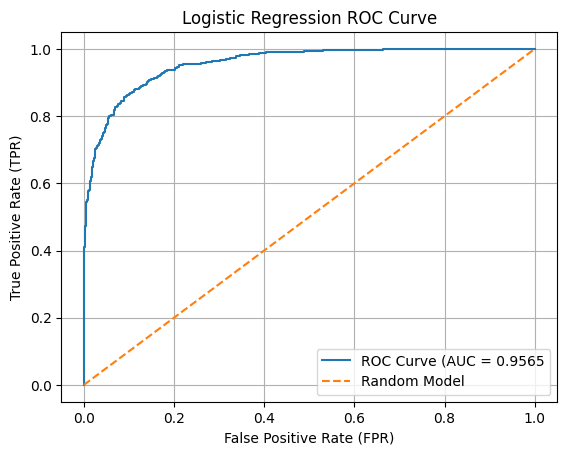

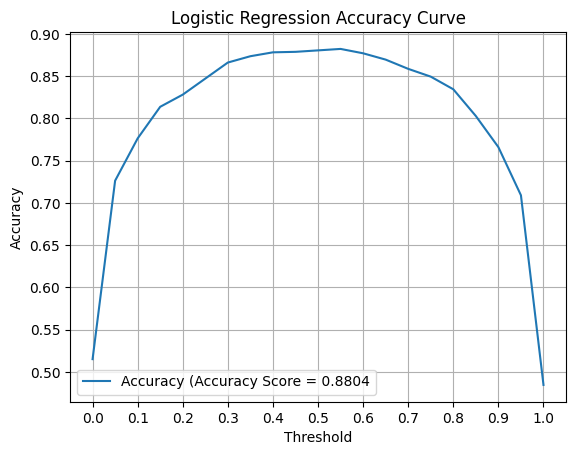


Ridge Classifier:

RMSE: 0.3597
MAE: 0.1294
R²: 0.4820
Accuracy: 0.8706

Random Forest Classifier:

RMSE: 0.0865
MAE: 0.0075
R²: 0.9701
Accuracy: 0.9925
ROC-AUC: 0.9999



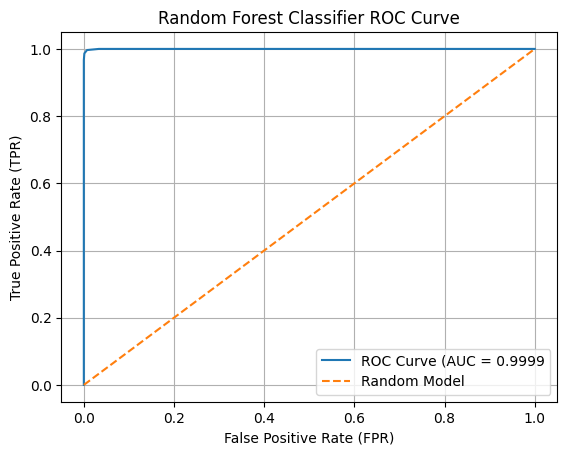

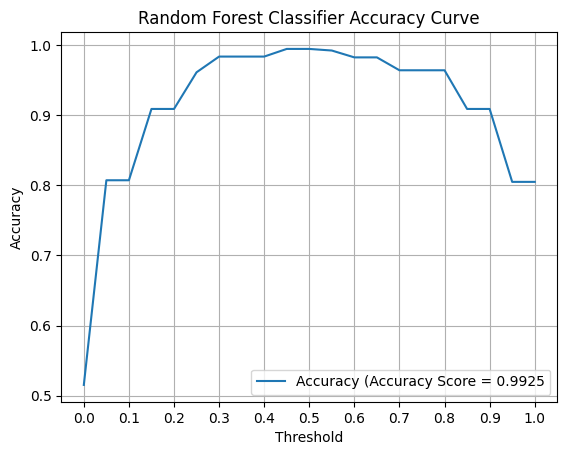


Support Vector Machines:

RMSE: 0.4461
MAE: 0.1990
R²: 0.2034
Accuracy: 0.8010
ROC-AUC: 0.8429



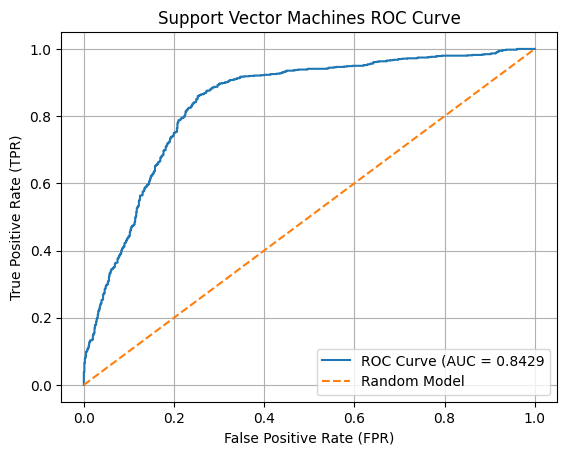

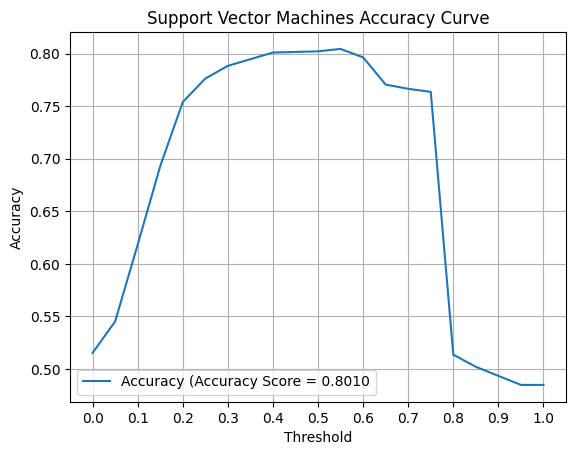


XGBoost:

RMSE: 0.1535
MAE: 0.0236
R²: 0.9056
Accuracy: 0.9764
ROC-AUC: 0.9972



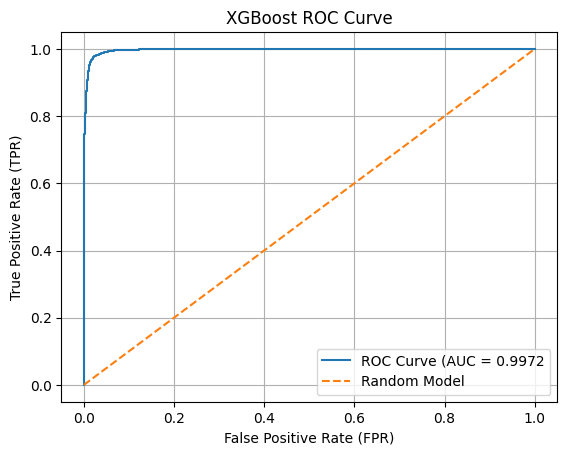

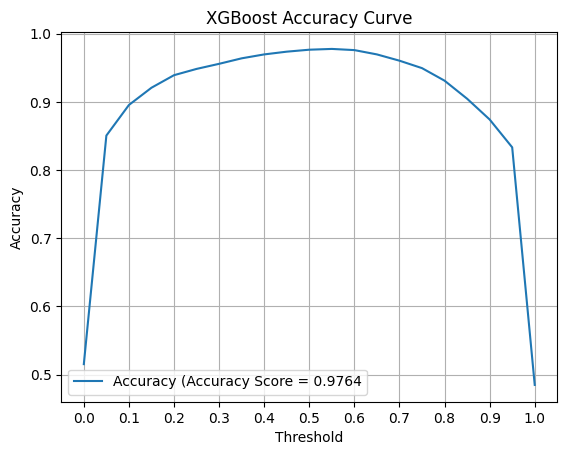

In [562]:
get_model_metrics()

### Thoughts on the Models

Logistic Regression:

RMSE: 0.3458\
MAE: 0.1196\
R²: 0.5211\
Accuracy: 0.8804\
ROC-AUC: 0.9565

- These metrics are reasonable for a well-performing Logistic Regression model.
- The ROC-AUC (0.9565) is pretty high, this shows excellent class separation.
- The R² (0.5211) suggests that the model explains about 52% of the variance in the target variable, which is moderate but acceptable for a binary classification problem.

Ridge Classifier:

RMSE: 0.3597\
MAE: 0.1294\
R²: 0.4820\
Accuracy: 0.8706

- These metrics are slightly worse than Logistic Regression, which is expected since Ridge Classifier is a simpler linear model.
- The Accuracy (0.8706) and R² (0.4820) are reasonable for a linear model.
- Ridge Classifier does not naturally produce probabilities, which limits its interpretability compared to Logistic Regression.

Random Forest:

RMSE: 0.0865\
MAE: 0.0075\
R²: 0.9701\
Accuracy: 0.9925\
ROC-AUC: 0.9999

- These metrics are extremely high and this usually means one of the following issues:
    - Overfitting: The model may have memorized the training data and is performing extremely well on the validation set by chance.
    - Data Leakage: Ensure that the validation set is completely separate from the training set and that no information from the validation set was used during training.
    - Incorrect Evaluation: Double-check that the predictions (y_pred_random_forest) and probabilities (y_pred_random_forest_proba) are being calculated correctly.
    - Class Imbalance: If the dataset is highly imbalanced (e.g., 99% of samples belong to one class), the model might achieve high accuracy by simply predicting the majority class. Check the class distribution:

Support Vector Machines:

RMSE: 0.4461\
MAE: 0.1990\
R²: 0.2034\
Accuracy: 0.8010\
ROC-AUC: 0.8429

- The SVM model performs worse compared to the other models, with lower accuracy (0.8010) and R² (0.2034). This is not uncommon for SVMs, especially if the data is not linearly separable or if the kernel and hyperparameters are not optimized.
- The ROC-AUC (0.8429) is moderate, indicating that the model has some ability to distinguish between classes but is not as strong as other models.
- SVMs can struggle with large datasets or datasets with overlapping classes, so this performance might be expected.

XGBoost:

RMSE: 0.1535\
MAE: 0.0236\
R²: 0.9056\
Accuracy: 0.9764\
ROC-AUC: 0.9972

- XGBoost is a model that usually performs rather high, with high accuracy (0.9764) and an outstanding ROC-AUC (0.9972). This suggests that the model is highly effective at distinguishing between classes.
- The R² (0.9056) indicates that the model explains a large proportion of the variance in the target variable, which is excellent for a classification task.
- However, the extremely high performance (especially ROC-AUC) should be carefully validated to rule out overfitting or data leakage. If the results hold, XGBoost is likely the best-performing model for this task.

### Addressing Model Evaluations

For the Random Forest model, the validation set is separate from the training set, the evaluations are being done correctly, and the Transported class is not imbalanced. The issue that makes the most sense is overfitting, let's fix it.

In [563]:
random_forest_classifier = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1)
random_forest_classifier.fit(X_train, y_train)
y_pred_random_forest_classifier = random_forest_classifier.predict(X_val)
y_pred_random_forest_classifier_proba = random_forest_classifier.predict_proba(X_val)[:, 1]


Random Forest Classifier:

RMSE: 0.3859
MAE: 0.1489
R²: 0.4037
Accuracy: 0.8511
ROC-AUC: 0.9354



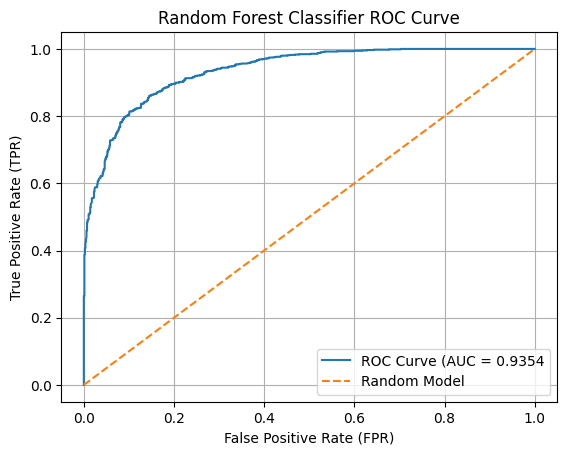

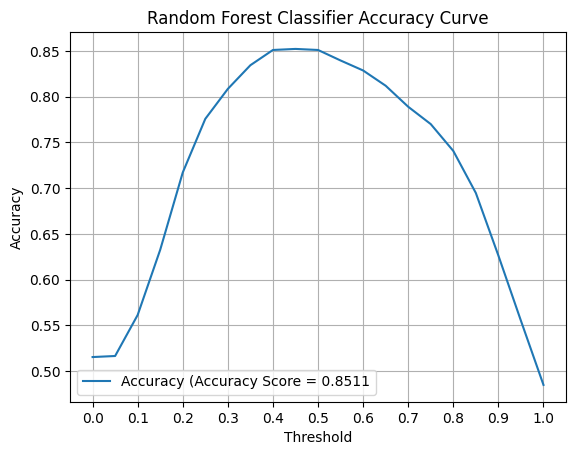

In [564]:
get_model_metrics(specific_model={"Random Forest Classifier": evaluate_model(y_val, y_pred_random_forest_classifier, y_pred_random_forest_classifier_proba)})

These graphs look a lot more likely. What we changed was set max_depth to 5 because if the trees are too deep, they can memorize the training data. The updated metrics suggest that the model is still performing well and is less likely to be overfitting the training data.

The best performing models from the 5 we evaluated seem to be Logistic Regression, Random Forest, and XGBoost. Let's use the test data with those models and then select the overall best performing model.

## Step 6: Deployment

The 3 models that we will be deploying will be Logistic Regression, Random Forest, and XGBoost. These models all have probabilities, so let's use them to get the optimal threshold for them.

In [565]:
def find_optimal_threshold(y_val, y_val_proba):
    thresholds = np.linspace(0, 1, 21)
    accuracies = [accuracy_score(y_val, y_val_proba >= threshold) for threshold in thresholds]
    optimal_threshold = thresholds[np.argmax(accuracies)]
    return optimal_threshold

In [566]:
find_optimal_threshold(y_val, y_pred_logistic_regression_proba)

np.float64(0.55)

In [567]:
find_optimal_threshold(y_val, y_pred_random_forest_classifier_proba)

np.float64(0.45)

In [568]:
find_optimal_threshold(y_val, y_pred_xgboost_proba)

np.float64(0.55)

### Selecting the Best Model

In [569]:
X_test = test_df

In [570]:
y_test_logistic_regression = (logistic_regression.predict_proba(X_test)[:, 1] >= find_optimal_threshold(y_val, y_pred_logistic_regression_proba))
y_test_logistic_regression.mean()

np.float64(0.4592003740939911)

In [571]:
y_test_random_forest_classifier = (random_forest_classifier.predict_proba(X_test)[:, 1] >= find_optimal_threshold(y_val, y_pred_random_forest_classifier_proba))
y_test_random_forest_classifier.mean()

np.float64(0.5426700958615852)

In [572]:
y_test_xgboost = (xgboost.predict_proba(X_test)[:, 1] >= find_optimal_threshold(y_val, y_pred_xgboost_proba))
y_test_xgboost.mean()

np.float64(0.48258124853869533)

In [573]:
global_mean

np.float64(0.5036236051995858)

The value for y_test_xgboost seems a lot more in line with the global_mean value from the train dataset, let's go with it and save it to a csv.

In [574]:
def create_csv(model, y_test, threshold):
    pd.DataFrame({
        "PassengerId": ids,
        "Transported": y_test
    }).to_csv(f"submission_{model}_{threshold}.csv", index=False)

In [580]:
create_csv("xgboost", (xgboost.predict_proba(X_test)[:, 1] >= find_optimal_threshold(y_val, y_pred_xgboost_proba)), find_optimal_threshold(y_val, y_pred_xgboost_proba))

Now we are done and can take a break.

Here are some more csv's tho.

In [588]:
create_csv("logistic_regression", (logistic_regression.predict_proba(X_test)[:, 1] >= .45), .45)

In [589]:
create_csv("logistic_regression", (logistic_regression.predict_proba(X_test)[:, 1] >= .5), .5)

In [590]:
create_csv("logistic_regression", (logistic_regression.predict_proba(X_test)[:, 1] >= .55), .55)

In [583]:
create_csv("random_forest", (random_forest_classifier.predict_proba(X_test)[:, 1] >= .45), .45)

In [584]:
create_csv("random_forest", (random_forest_classifier.predict_proba(X_test)[:, 1] >= .5), .5)

In [586]:
create_csv("random_forest", (random_forest_classifier.predict_proba(X_test)[:, 1] >= .55), .55)

In [582]:
create_csv("xgboost", (xgboost.predict_proba(X_test)[:, 1] >= .45), .45)

In [581]:
create_csv("xgboost", (xgboost.predict_proba(X_test)[:, 1] >= .5), .5)

In [587]:
create_csv("xgboost", (xgboost.predict_proba(X_test)[:, 1] >= .55), .55)

### What I Learned:

- What SVM is and how to implement it.
- df.dtypes[df.dtypes == "object"].drop(column).index is a good way to get the columns for one-hot and target encoding while excluding a/some column(s).
- How to fix overfitting in Random Forest Models.
- How to use XGBClassifier.

### What to Do Next Time:

- Have a plot that plots the ROC Curves and Accuracy Curves for all of the models on one plot. This way you can more closely see which models have the best ROC Curve and Accuracy Curve.
- Add a confusion matrix. A confusion matrix could provide more insight into the model’s performance, especially for imbalanced datasets.